<a href="https://colab.research.google.com/github/rahil1303/dmt-assignment1-2025/blob/main/notebooks/04_association_rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rulesb


In [2]:
# Step 1: Clone the repo
!git clone https://github.com/rahil1303/dmt-assignment1-2025.git

# Step 2: Change directory to your repo
%cd dmt-assignment1-2025

# Step 3: Install dependencies (optional)
!pip install -r requirements.txt

Cloning into 'dmt-assignment1-2025'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 63 (delta 28), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 230.54 KiB | 1.68 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/dmt-assignment1-2025


In [3]:
# Load and clean
df = pd.read_excel('data/ODI-2025.xlsx')
df.columns = df.columns.str.strip()

# Binary features
df['ChatGPT_Yes'] = df['I have used ChatGPT to help me with some of my study assignments'].map(lambda x: x == 'yes')
df['ML_Yes'] = df['Have you taken a course on machine learning?'].map(lambda x: x == 'yes')

# Sports bucket
df['LowSports'] = df['How many hours per week do you do sports (in whole hours)?'].apply(
    lambda x: str(x).isdigit() and int(x) < 3
)

# Bedtime bucket
import re
def late_bedtime(x):
    match = re.match(r'(\d{1,2})', str(x))
    if match:
        hour = int(match.group(1))
        return hour >= 23
    return False

df['LateBed'] = df['Time you went to bed Yesterday'].apply(late_bedtime)

# Stress bucket
df['Stress_High'] = pd.to_numeric(df['What is your stress level (0-100)?'], errors='coerce') > 66


In [4]:
# Select only binary columns
bin_cols = ['ChatGPT_Yes', 'ML_Yes', 'LowSports', 'LateBed', 'Stress_High']
df_bin = df[bin_cols].dropna().astype(bool)

# Apply Apriori
frequent = apriori(df_bin, min_support=0.1, use_colnames=True)

# Extract strong rules
rules = association_rules(frequent, metric="confidence", min_threshold=0.7)
rules.sort_values(by='confidence', ascending=False, inplace=True)

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
6,(LateBed),(ML_Yes),0.204082,0.925926,1.175398
10,"(ChatGPT_Yes, LateBed)",(ML_Yes),0.183673,0.918367,1.165803
3,(LateBed),(ChatGPT_Yes),0.200000,0.907407,1.176269
11,"(ML_Yes, LateBed)",(ChatGPT_Yes),0.183673,0.900000,1.166667
12,(LateBed),"(ChatGPT_Yes, ML_Yes)",0.183673,0.833333,1.379505
13,"(ChatGPT_Yes, Stress_High)",(ML_Yes),0.167347,0.803922,1.020522
0,(ChatGPT_Yes),(ML_Yes),0.604082,0.783069,0.994051
7,(Stress_High),(ML_Yes),0.228571,0.777778,0.987334
1,(ML_Yes),(ChatGPT_Yes),0.604082,0.766839,0.994051
9,"(ML_Yes, LowSports)",(ChatGPT_Yes),0.102041,0.757576,0.982043


## 🔗 Top Association Rules (Support ≥ 10%, Confidence ≥ 70%)

| If (Antecedents)               | Then (Consequent)           | Confidence | Lift   |
|--------------------------------|------------------------------|------------|--------|
| Late to bed                    | → ML background             | **0.93**   | 1.18   |
| ChatGPT user + Late to bed     | → ML background             | **0.92**   | 1.17   |
| Late to bed                    | → ChatGPT user              | **0.91**   | 1.18   |
| ML background + Late to bed    | → ChatGPT user              | **0.90**   | 1.17   |
| Late to bed                    | → ChatGPT + ML background   | **0.83**   | 1.38   |
| ChatGPT user + High stress     | → ML background             | **0.80**   | 1.02   |
| ChatGPT user                   | → ML background             | **0.78**   | ~1.00  |
| High stress                    | → ML background             | **0.78**   | ~0.99  |
| ML background                  | → ChatGPT user              | **0.77**   | ~1.00  |
| ML background + Low sports     | → ChatGPT user              | **0.76**   | 0.98   |

### 🧠 Insights:
- Students who **sleep late** often have **ML background** and **use ChatGPT**.
- **ChatGPT users** are very likely to also have a **machine learning background**.
- **High-stress students** are moderately associated with having an ML background, though the lift is weak.


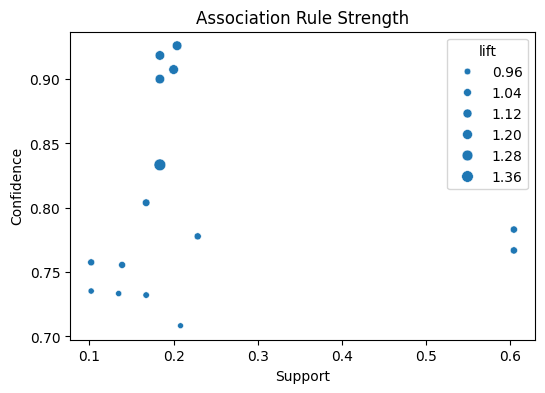

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules)
plt.title("Association Rule Strength")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()


## 📊 Association Rule Mining – Summary

- **Method**: Apriori algorithm on binarized student attributes
- **Features used**:
  - ChatGPT usage
  - ML course background
  - Low sports hours
  - Late bedtime
  - High stress (binned)

### 🔍 Key Findings:
- Students who sleep late are highly likely to also use ChatGPT and have an ML background.
- Low sports activity + ML background shows some overlap with ChatGPT usage.
- High stress is weakly linked to ChatGPT and ML background, but confidence is moderate (~0.78) and lift ~1.

> While these associations are not causative, they provide a glimpse into behavioral clusters among students.

📈 *See the scatter plot for rule strength based on support, confidence, and lift.*
